Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../ML_tools/src/")

sys.path.append("../src/")


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler


## Download the data

Commands to download and extract the data;
```sh
mkdir data
wget https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip -P data
# Extrac all data
unzip data/sleep-edf-database-expanded-1.0.0.zip -d data
```

# Data loading

## Some EDF loading funcs

In [5]:
from data import load_signals, load_annotations, annotation_to_30s_labels

## Load some data

In [6]:
data_folder = "../../../../data/sleep/sleep-edf-database-expanded-1.0.0/"

os.listdir(data_folder)


['sleep-telemetry',
 'RECORDS-v1',
 'SHA256SUMS.txt',
 'SC-subjects.xls',
 'sleep-cassette',
 'ST-subjects.xls',
 'RECORDS']

In [7]:
os.listdir(data_folder + "sleep-cassette")[:10]


['SC4802G0-PSG.edf',
 'SC4242E0-PSG.edf',
 'SC4231E0-PSG.edf',
 'SC4561FJ-Hypnogram.edf',
 'SC4632EA-Hypnogram.edf',
 'SC4522EM-Hypnogram.edf',
 'SC4812GV-Hypnogram.edf',
 'SC4771GC-Hypnogram.edf',
 'SC4641E0-PSG.edf',
 'SC4561F0-PSG.edf']

In [8]:
len(os.listdir(data_folder + "sleep-cassette"))


306

In [9]:
!du -hs ../../../../data/sleep/sleep-edf-database-expanded-1.0.0/sleep-cassette

7.1G	../../../../data/sleep/sleep-edf-database-expanded-1.0.0/sleep-cassette


=> In total 306 files (153 PSG files - 153 hypnogram files) => 7.1 GB

In [10]:
dfs = []
sub_folder = "sleep-cassette"
sorted_files = sorted(os.listdir(data_folder + sub_folder))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder

# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
df_files


,psg_file,label_file,subfolder,patient_id
0,SC4001E0-PSG.edf,SC4001EC-Hypnogram.edf,sleep-cassette,SC400
1,SC4002E0-PSG.edf,SC4002EC-Hypnogram.edf,sleep-cassette,SC400
2,SC4011E0-PSG.edf,SC4011EH-Hypnogram.edf,sleep-cassette,SC401
3,SC4012E0-PSG.edf,SC4012EC-Hypnogram.edf,sleep-cassette,SC401
4,SC4021E0-PSG.edf,SC4021EH-Hypnogram.edf,sleep-cassette,SC402
...,...,...,...,...
148,SC4802G0-PSG.edf,SC4802GV-Hypnogram.edf,sleep-cassette,SC480
149,SC4811G0-PSG.edf,SC4811GG-Hypnogram.edf,sleep-cassette,SC481
150,SC4812G0-PSG.edf,SC4812GV-Hypnogram.edf,sleep-cassette,SC481
151,SC4821G0-PSG.edf,SC4821GC-Hypnogram.edf,sleep-cassette,SC482


In [11]:
paper_patients = [
    "SC400",
    "SC401",
    "SC402",
    "SC403",
    "SC404",
    "SC405",
    "SC406",
    "SC407",
    "SC408",
    "SC409",
    "SC410",
    "SC411",
    "SC412",
    "SC413",
    "SC414",
    "SC415",
    "SC416",
    "SC417",
    "SC418",
    "SC419",
]


In [12]:
df_files_paper = df_files[df_files.patient_id.isin(paper_patients)]
df_files_paper.psg_file.nunique()


39

In [13]:
df_files_paper.patient_id.nunique()


20

=> psg file can be used as recordingid   
=> patient id can be used as patient id 

In [14]:
df_files_other = df_files[~df_files.patient_id.isin(paper_patients)]
df_files_other.psg_file.nunique()


114

In [15]:
df_files_other.patient_id.nunique()


58

In [16]:
signal_dict = {}

for idx in range(len(df_files)):
    sig, freq = load_signals(
        data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file,
        only_info=True,
    )
    for s, f in zip(sig, freq):
        if (s, f) in signal_dict.keys():
            signal_dict[(s, f)].append(idx)
        else:
            signal_dict[(s, f)] = [idx]

# Displays (sig, freq) #recordings
[(k, len(v)) for k, v in signal_dict.items()]


[(('EEG Fpz-Cz', 100), 153),
 (('EEG Pz-Oz', 100), 153),
 (('EOG horizontal', 100), 153),
 (('Resp oro-nasal', 1), 153),
 (('EMG submental', 1), 153),
 (('Temp rectal', 1), 153),
 (('Event marker', 1), 153)]

In [17]:
common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]


In [18]:
data = load_signals(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
    retrieve_signals=common_signals,
)
annotations = load_annotations(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
)


In [19]:
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]


# EDA + pipeline (for 1 patient)

In [20]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[],
            y=[],
            name=s.name,
            line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[],
        y=[],
        name="Hypnogram",
        line_width=1.5,
        line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_dark",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8041)


Dash app running on http://127.0.0.1:8041/


## Process the signals

In [21]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


# def clipper(sig, min_q=0, max_q=1):
#     return sig.clip(sig.quantile(min_q), sig.quantile(max_q))


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
    ]
)

process_pipe


[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
]

In [22]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

CPU times: user 392 ms, sys: 88.5 ms, total: 481 ms
Wall time: 469 ms


In [23]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.show_dash(port=8041)


Dash app running on http://127.0.0.1:8041/


## Extract the features

In [24]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings


{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [25]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])
# fc


In [26]:
import logging

from tsflex.features.logger import logger

logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger

logger.setLevel(level=logging.ERROR)


In [27]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats


  0%|          | 0/261 [00:00<?, ?it/s]

,EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s,EEG Fpz-Cz__TotalAbsPow__w=2m_s=30s,EEG Fpz-Cz__TotalAbsPow__w=30s_s=30s,EEG Fpz-Cz__alpha__w=1m_s=30s,EEG Fpz-Cz__alpha__w=2m_s=30s,EEG Fpz-Cz__alpha__w=30s_s=30s,EEG Fpz-Cz__beta__w=1m_s=30s,EEG Fpz-Cz__beta__w=2m_s=30s,EEG Fpz-Cz__beta__w=30s_s=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m_s=30s,...,EOG horizontal__skew__w=30s_s=30s,EOG horizontal__std__w=1m_s=30s,EOG horizontal__std__w=2m_s=30s,EOG horizontal__std__w=30s_s=30s,EOG horizontal__theta__w=1m_s=30s,EOG horizontal__theta__w=2m_s=30s,EOG horizontal__theta__w=30s_s=30s,EOG horizontal__wrapped_higuchi_fd__w=1m_s=30s,EOG horizontal__wrapped_higuchi_fd__w=2m_s=30s,EOG horizontal__wrapped_higuchi_fd__w=30s_s=30s
1989-04-24 16:13:30,NaN,NaN,552.556158,NaN,NaN,0.011966,NaN,NaN,0.01293,NaN,...,0.173134,NaN,NaN,71.403606,NaN,NaN,0.031219,NaN,NaN,1.257986
1989-04-24 16:14:00,410.013414,NaN,296.813297,0.018171,NaN,0.028862,0.024353,NaN,0.046444,1.667629,...,0.203721,73.886409,NaN,76.288450,0.042809,NaN,0.058202,1.488313,NaN,1.641231
1989-04-24 16:14:30,284.113885,NaN,358.240748,0.032559,NaN,0.032287,0.03873,NaN,0.027552,1.564244,...,-0.279640,70.765891,NaN,64.774158,0.032964,NaN,0.025595,1.607514,NaN,1.563791
1989-04-24 16:15:00,206.055516,274.098927,187.837507,0.056282,0.031379,0.074854,0.03516,0.029921,0.028251,1.431736,...,0.029593,47.508646,62.113901,17.845006,0.064335,0.048579,0.100081,1.660663,1.561266,1.830498
1989-04-24 16:15:30,177.742607,195.583538,173.517873,0.068842,0.049285,0.059463,0.027978,0.035678,0.027121,1.376963,...,-0.439511,16.211393,51.335451,14.390960,0.10672,0.070855,0.111054,1.828444,1.678465,1.827002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-04-25 14:15:30,212.469296,365.298966,255.230551,0.036642,0.021682,0.030919,0.047035,0.02709,0.034681,1.535747,...,0.067072,56.496391,73.646179,62.682500,0.058822,0.050555,0.045841,1.569018,1.539274,1.519734
1989-04-25 14:16:00,204.06735,259.104469,162.540943,0.035044,0.02872,0.035758,0.040611,0.036018,0.051777,1.621815,...,0.001826,60.120669,63.059999,57.442227,0.045717,0.053193,0.053498,1.611479,1.627724,1.687073
1989-04-25 14:16:30,203.696881,214.195007,287.986357,0.036019,0.03443,0.026256,0.047291,0.044602,0.034697,1.413289,...,-0.010830,66.556921,61.732264,74.564612,0.059213,0.05594,0.064801,1.699283,1.643647,1.711871
1989-04-25 14:17:00,217.303883,215.533895,184.806999,0.037448,0.035516,0.047466,0.042533,0.041467,0.047973,1.410208,...,-0.041717,67.617997,63.979359,59.867784,0.056196,0.049941,0.046247,1.638321,1.624705,1.516722


# Pipeline for all patients

In [ ]:
from tqdm.auto import tqdm

df_feats = []
for sub_folder, psg_file, hypnogram_file in tqdm(
    zip(df_files.subfolder, df_files.psg_file, df_files.label_file)
):
    file_folder = data_folder + sub_folder + "/"
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file[:5]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

0it [00:00, ?it/s]

/users/jonvdrdo/jeroen/git/sleep-linear/venv/lib/python3.7/site-packages/antropy/entropy.py:1012: RuntimeWarning:

invalid value encountered in double_scalars

/users/jonvdrdo/jeroen/git/sleep-linear/venv/lib/python3.7/site-packages/antropy/entropy.py:1012: RuntimeWarning:

invalid value encountered in double_scalars

/users/jonvdrdo/jeroen/git/sleep-linear/venv/lib/python3.7/site-packages/antropy/entropy.py:1011: RuntimeWarning:

invalid value encountered in double_scalars

/users/jonvdrdo/jeroen/git/sleep-linear/venv/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:1799: RuntimeWarning:

invalid value encountered in true_divide

/users/jonvdrdo/jeroen/git/sleep-linear/venv/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:1799: RuntimeWarning:

invalid value encountered in true_divide

/users/jonvdrdo/jeroen/git/sleep-linear/venv/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:1799: RuntimeWarning:

In [ ]:
df_feats.to_parquet("../features/sleep-edf__cassette_features_ALL.parquet")


## Load data

In [28]:
df_feats = pd.read_parquet("../features/sleep-edf__cassette_features_ALL.parquet")
df_feats.shape

(416271, 366)

In [29]:
df_feats["label"].value_counts()

Sleep stage W    285286
Sleep stage 2     69132
Sleep stage R     25835
Sleep stage 1     21521
Sleep stage 3      8793
Sleep stage 4      4246
Sleep stage ?      1330
Movement time       128
Name: label, dtype: int64

In [30]:
df_feats[~df_feats.psg_file.isin(df_files.psg_file.unique())].psg_file.nunique()

0

In [31]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s to patient_id
dtypes: float32(363), object(3)
memory usage: 589.1+ MB


In [32]:
eeg_signals = [d for d in common_signals if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [
        c
        for c in df_feats.columns
        if c.startswith(eeg_sig) and c.split("__")[1] in bands
    ]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = (
            df_feats["__".join([eeg_sig, "sdelta", window])]
            + df_feats["__".join([eeg_sig, "fdelta", window])]
        )
        fdelta_theta = (
            df_feats["__".join([eeg_sig, "fdelta", window])]
            + df_feats["__".join([eeg_sig, "theta", window])]
        )
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype(
            "float32"
        )

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype(
            "float32"
        )
df_feats.shape

(416271, 396)

In [33]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [34]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(2).add_suffix("_shift=1m"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"),
        left_index=True,
        right_index=True,
    )
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape


(416271, 920)

In [35]:
df_feats.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 920 entries, EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s to EEG Pz-Oz__delta/theta__w=30s_s=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 1.4+ GB


In [36]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[
    df_feats["label"] != "Sleep stage ?"
]  # Label that is given when recording is done / end of the night


In [37]:
df_feats_paper = df_feats[df_feats.psg_file.isin(df_files_paper.psg_file)]
df_feats_paper.shape


(106377, 920)

In [38]:
def get_repeat_length(val, arr):
    assert arr[0] == val
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats_paper["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_paper = pd.concat(dfs)
del dfs


In [39]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_all = pd.concat(dfs)
del dfs


Prepare training data for SleepEDF-20

In [40]:
# Subset of data that does not contain the SC-EDF-20 patients
df_feats_trimmed = df_feats_trimmed_all[
    ~df_feats_trimmed_all.psg_file.isin(df_feats_trimmed_paper.psg_file.unique())
]
df_feats_trimmed.shape


(152938, 920)

In [41]:
any(
    [
        psg_file in df_feats_trimmed_paper.psg_file.unique()
        for psg_file in df_feats_trimmed
    ]
)


False

In [42]:
df_feats_trimmed["label"].value_counts()


Sleep stage W    57435
Sleep stage 2    51333
Sleep stage 1    18716
Sleep stage R    18118
Sleep stage 3     7336
Name: label, dtype: int64

In [43]:
# Label stats for the SC-EDF-20 data
print(len(df_feats_trimmed_paper))
df_feats_trimmed_paper["label"].value_counts()


42230


Sleep stage 2    17799
Sleep stage W     8207
Sleep stage R     7717
Sleep stage 3     5703
Sleep stage 1     2804
Name: label, dtype: int64

Matches with the samples from other papers

In [44]:
# Label stats for the SC-EDFx data
print(len(df_feats_trimmed_all))
df_feats_trimmed_all["label"].value_counts()


195168


Sleep stage 2    69132
Sleep stage W    65642
Sleep stage R    25835
Sleep stage 1    21520
Sleep stage 3    13039
Name: label, dtype: int64

The trimmed wake value count now matches (roughly) the amount of the IITNet & DeepSleepNet paper

## EDA on labels

<AxesSubplot:>

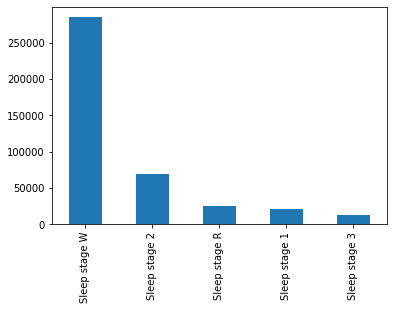

In [45]:
df_feats["label"].value_counts().plot(kind="bar")


<AxesSubplot:>

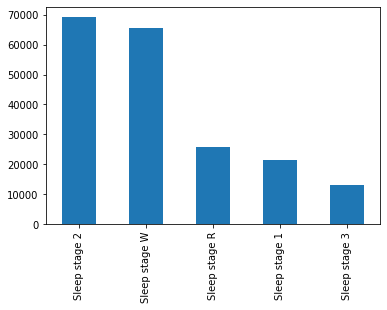

In [46]:
df_feats_trimmed_all["label"].value_counts().plot(kind="bar")


In [47]:
df_feats_trimmed_all["label"].value_counts()


Sleep stage 2    69132
Sleep stage W    65642
Sleep stage R    25835
Sleep stage 1    21520
Sleep stage 3    13039
Name: label, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [48]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]


In [49]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]

# n_cols = 10
# n_rows = math.ceil(len(plot_cols) / n_cols)
# plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

# for idx, col in enumerate(plot_cols):
#     plt.subplot(n_rows, n_cols, idx + 1)
#     plt.boxplot(df_feats_trimmed_all[col].dropna(), vert=True)
#     plt.xlabel(col)

# plt.tight_layout()
# plt.show()


# ML

In [50]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFpr, chi2

In [51]:
from ml_tools.visualizations.models_linear import plot_linear_classification_coefs
from ml_tools.visualizations.models import plot_learning_curve
from ml_tools.visualizations.evaluation import plot_confusion_matrix

## The simple, linear pipeline

In [52]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer()),
        ("selector", SelectFpr(chi2, alpha=1e-5)),
        (
            "linear_model",
            SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

## Linear model for SC-20

### Direct transfer from other 58 patients (114 PSGs) to SC-20

* Train & validatie on all patients except the SC-20 patients (i.e., patient_id > 19)
* Test the trained model on those 20 patients (i.e., patient_id in [0-19])

In [53]:
### Fit the pipeline
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])

Pipeline(steps=[('impute', SimpleImputer()), ('scale', QuantileTransformer()),
                ('selector',
                 SelectFpr(alpha=1e-05,
                           score_func=<function chi2 at 0x7fc95a6e6170>)),
                ('linear_model',
                 SGDClassifier(average=True, class_weight='balanced',
                               loss='log', n_jobs=5, random_state=0))])

In [54]:
print(sum(pipe["selector"].get_support()), "features selected")

905 features selected


In [55]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

Training data:
Log loss: 0.5456653587358519
               precision    recall  f1-score   support

Sleep stage 1       0.54      0.53      0.54     18716
Sleep stage 2       0.85      0.84      0.84     51333
Sleep stage 3       0.64      0.87      0.74      7336
Sleep stage R       0.82      0.85      0.84     18118
Sleep stage W       0.95      0.92      0.93     57435

     accuracy                           0.83    152938
    macro avg       0.76      0.80      0.78    152938
 weighted avg       0.84      0.83      0.83    152938



In [56]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

Testing data:
Log loss: 0.501092560278091
               precision    recall  f1-score   support

Sleep stage 1       0.50      0.45      0.47      2804
Sleep stage 2       0.91      0.87      0.89     17799
Sleep stage 3       0.84      0.93      0.88      5703
Sleep stage R       0.87      0.88      0.87      7717
Sleep stage W       0.90      0.92      0.91      8207

     accuracy                           0.86     42230
    macro avg       0.80      0.81      0.81     42230
 weighted avg       0.86      0.86      0.86     42230



In [57]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))


F1 macro:  0.8055827901828669
Bal. Acc:  0.8021675761234034
Kappa:     0.8133783897520209
Log loss : 0.501092560278091
Acc:       0.8633909542978925


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

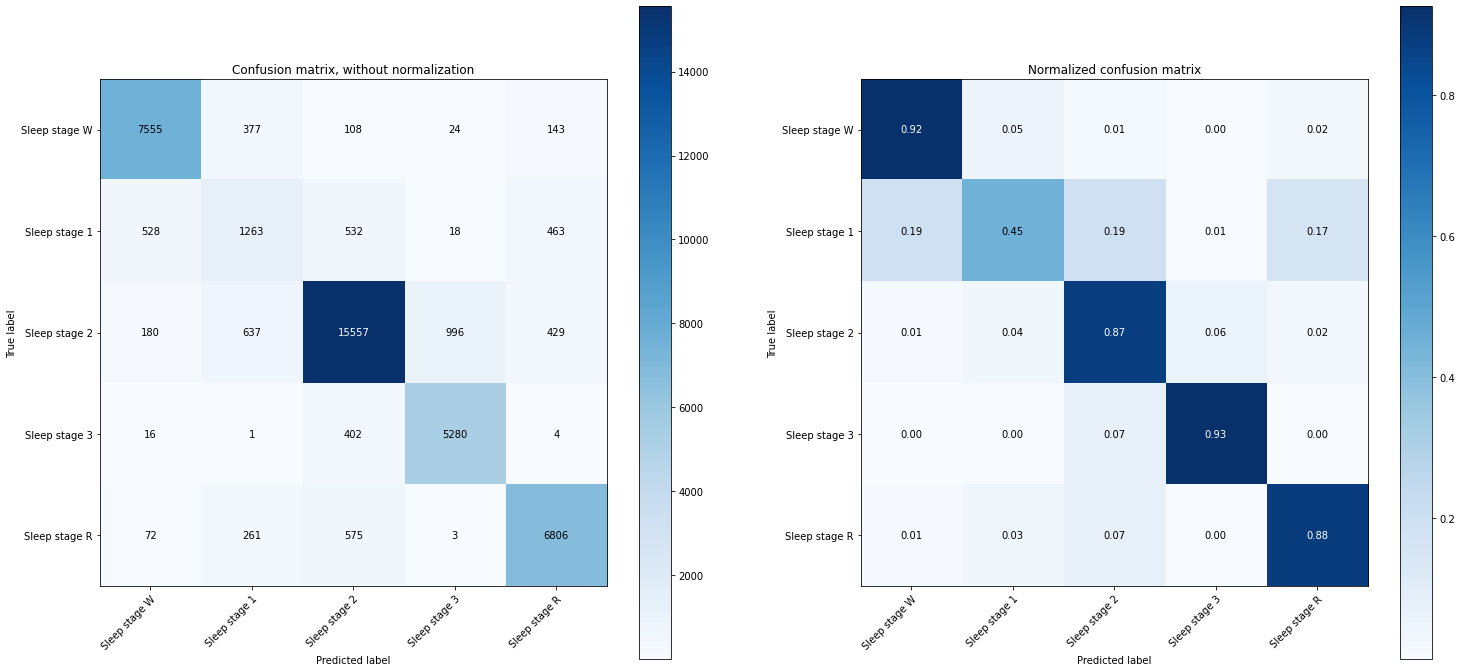

In [58]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

In [59]:
import joblib
joblib.dump(pipe, "../models/pipe_DT_SC-20.pkl")

['../models/pipe_DT_SC-20.pkl']

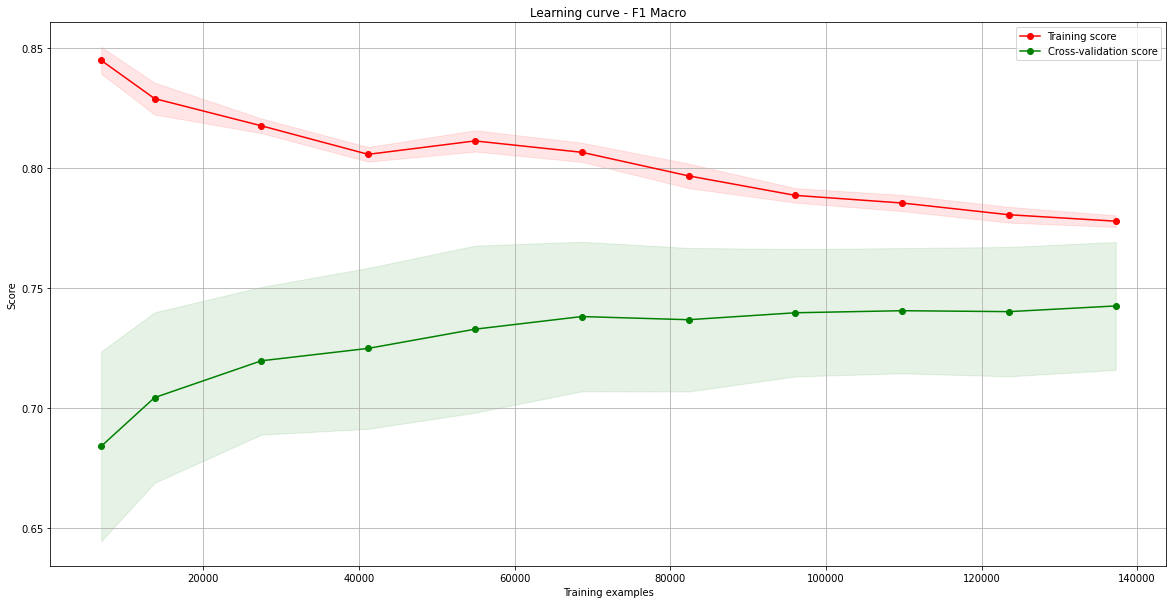

In [60]:
cv = StratifiedGroupKFold(n_splits=10).split(
    df_feats_trimmed[feat_cols],
    df_feats_trimmed["label"],
    groups=df_feats_trimmed.patient_id,
)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed[feat_cols],
    y=df_feats_trimmed["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=25,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)


#### Basic model analysis

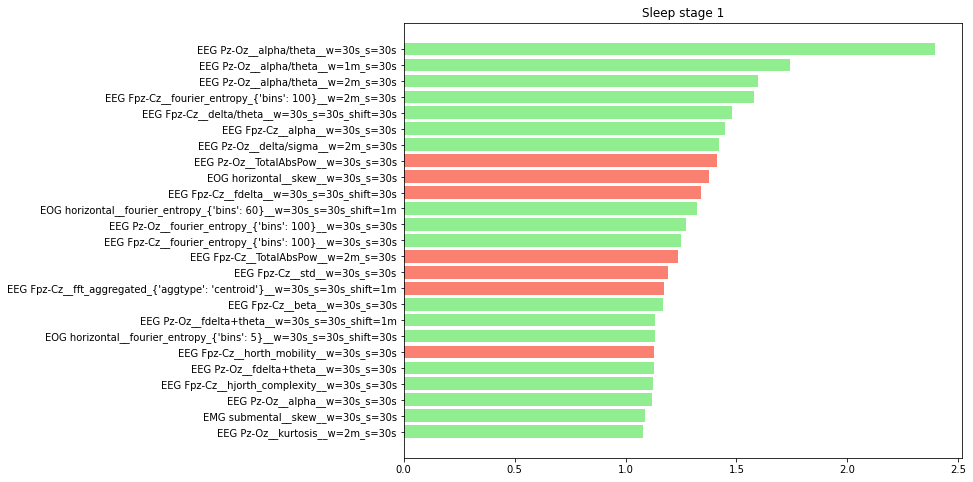

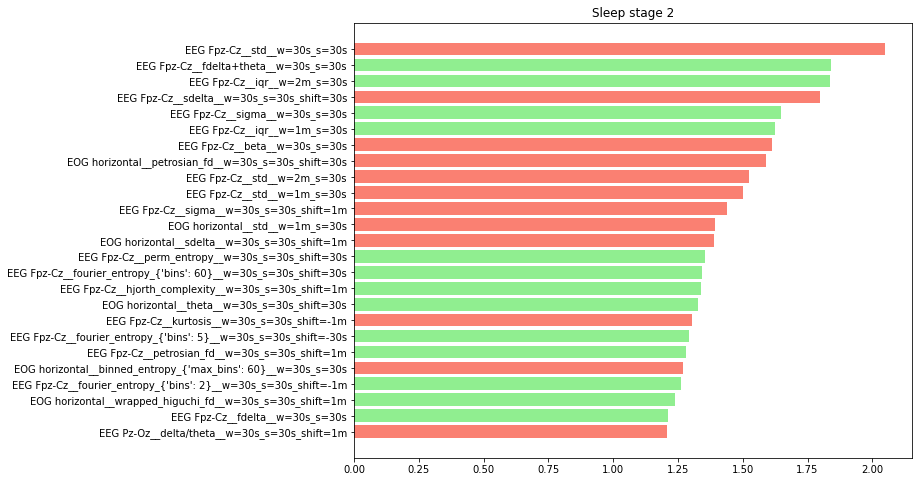

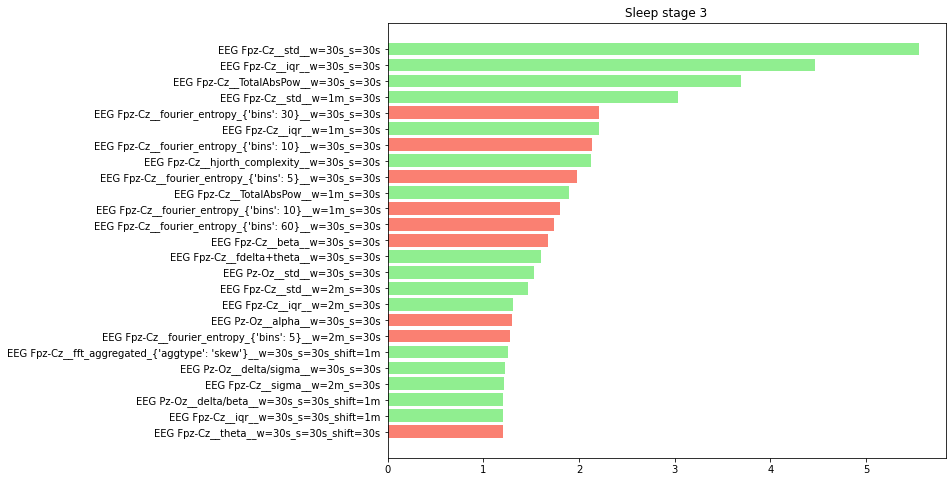

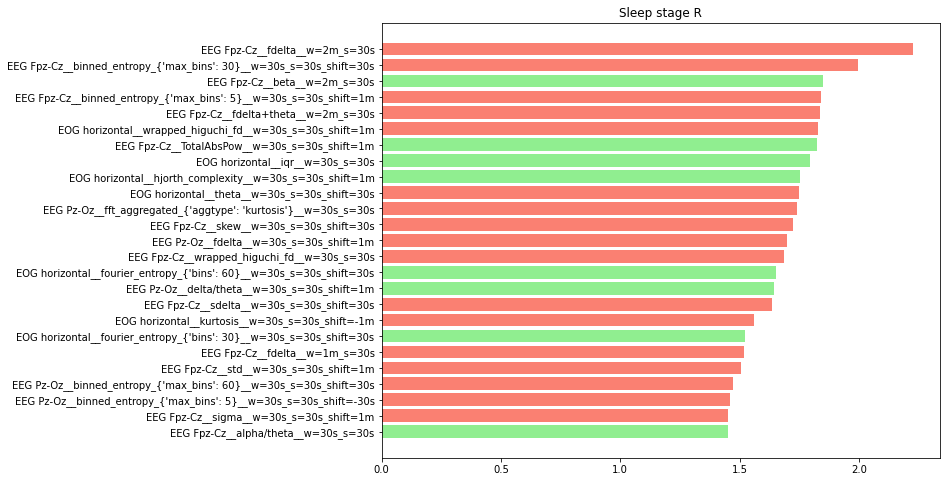

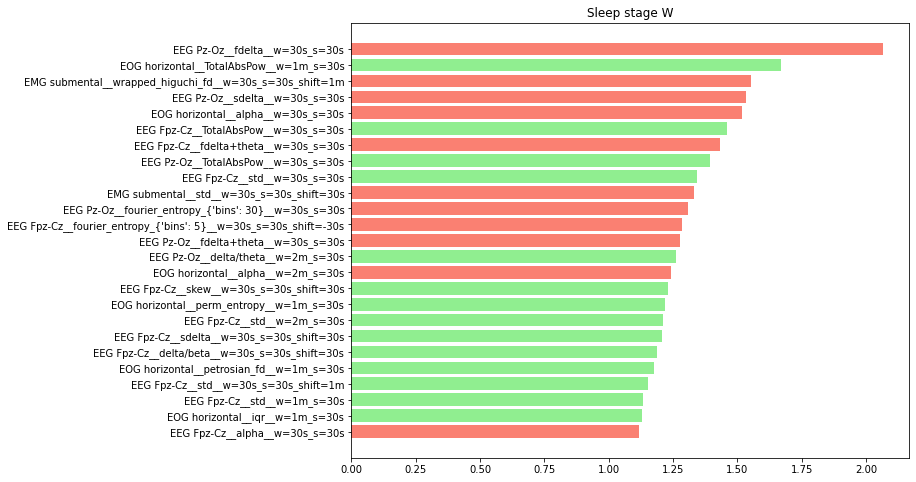

In [61]:
plot_linear_classification_coefs(pipe, feat_cols=feat_cols)

### Grouped X-fold on SC-20

In [62]:
# Total of 20 folds
gkfold = GroupKFold(n_splits=20)
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [63]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))


20-FOLD: TRAIN
  MACRO F1:           0.8494
  Balanced accuracy:  0.8611
  Accuracy:           0.8883
  Log loss:           0.5523


In [64]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.7953
  Balanced accuracy:  0.8218
  Accuracy:           0.8549
  Log loss:           0.8636


In [65]:
preds = []
preds_proba = []
y_trues = []
selected_feats = []
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_paper[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_paper["label"].iloc[train_idx]
    X_test = df_feats_trimmed_paper[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_paper["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]
    selected_feats += [np.array(feat_cols)[estimator["selector"].get_support()]]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

917 features in total
fold 0  889 features selected
fold 1  889 features selected
fold 2  890 features selected
fold 3  889 features selected
fold 4  891 features selected
fold 5  889 features selected
fold 6  889 features selected
fold 7  889 features selected
fold 8  889 features selected
fold 9  898 features selected
fold 10  889 features selected
fold 11  888 features selected
fold 12  889 features selected
fold 13  889 features selected
fold 14  889 features selected
fold 15  889 features selected
fold 16  889 features selected
fold 17  889 features selected
fold 18  889 features selected
fold 19  890 features selected

888 features in intersection
898 features in union


Text(0.5, 0, 'times selected')

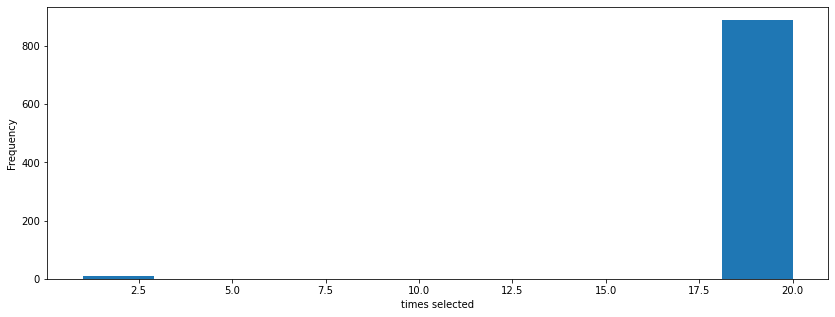

In [66]:
print(f"{len(feat_cols)} features in total")

selection_df = pd.DataFrame(data=set.union(*map(set, selected_feats)), columns=["feature"])
selection_df["times_selected"] = 0

for fold, feats in enumerate(selected_feats):
    print(f"fold {fold}  {len(feats)} features selected")
    selection_df.loc[selection_df.feature.isin(feats), "times_selected"] += 1

print()
print(f"{len(set.intersection(*map(set, selected_feats)))} features in intersection")
print(f"{len(set.union(*map(set, selected_feats)))} features in union")

ax = selection_df["times_selected"].plot(kind="hist", bins=10, figsize=(14,5))
plt.xlabel("times selected")

In [67]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8062801599933638
ACC: 0.8558370826426711
KAPPA: 0.8042274462718202
LOG LOSS: 0.8676373383525667


In [68]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.54      0.45      0.49      3366
Sleep stage 2       0.86      0.91      0.88     16812
Sleep stage 3       0.91      0.83      0.87      6248
Sleep stage R       0.89      0.87      0.88      7913
Sleep stage W       0.89      0.92      0.91      7891

     accuracy                           0.86     42230
    macro avg       0.82      0.80      0.81     42230
 weighted avg       0.85      0.86      0.85     42230



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

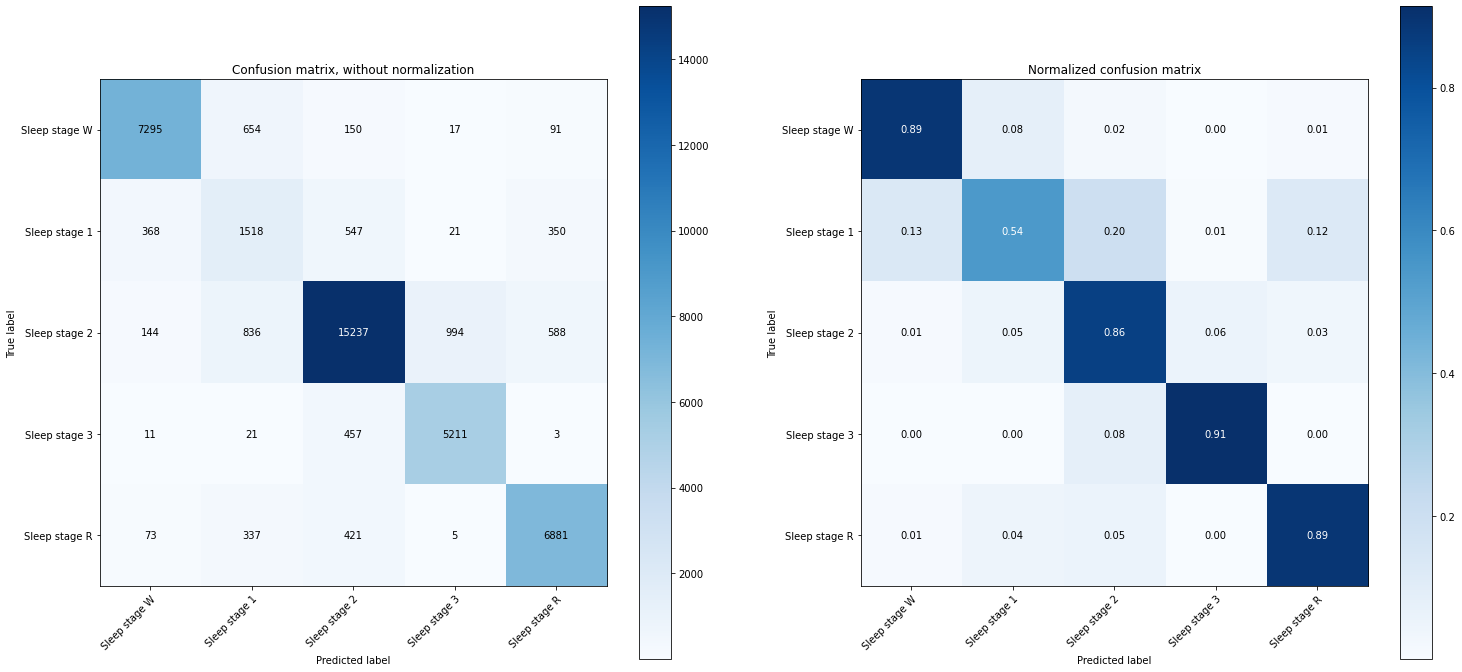

In [69]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

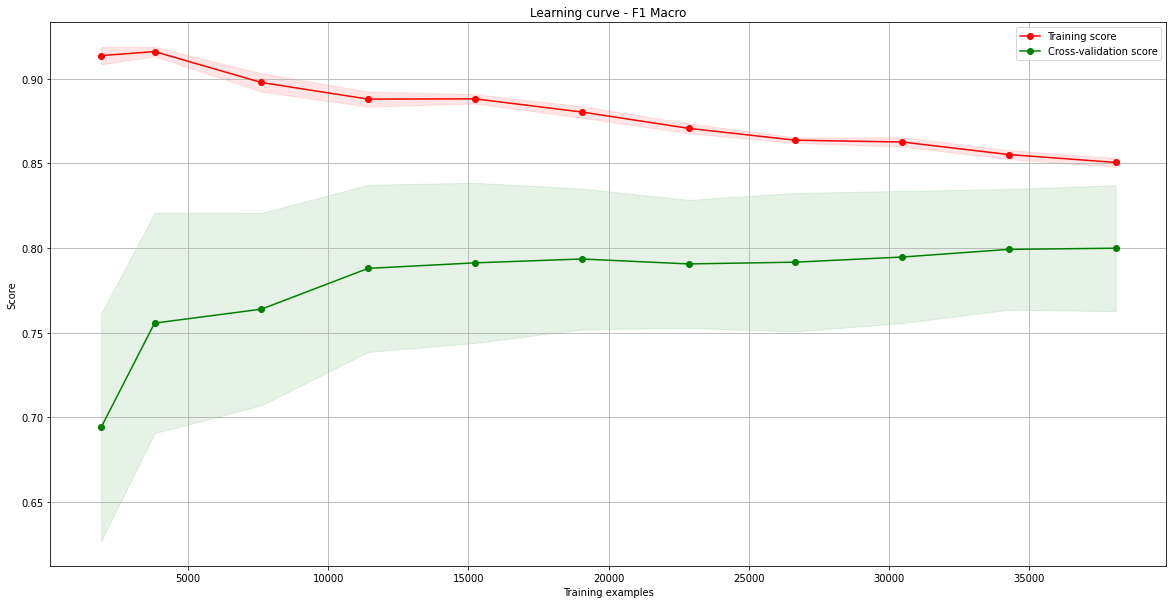

In [70]:
cv = StratifiedGroupKFold(n_splits=10).split(
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    groups=df_feats_trimmed_paper.patient_id,
)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed_paper[feat_cols],
    y=df_feats_trimmed_paper["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=20,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)


## Linear model for SC-78

### Grouped X-fold on all 78 patients (153 PSGs)

In [84]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [85]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))


10-FOLD: TRAIN
  MACRO F1:           0.7946
  Balanced accuracy:  0.8102
  Accuracy:           0.8407
  Log loss:           0.5204


In [86]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


10-FOLD: TEST
  MACRO F1:           0.7697
  Balanced accuracy:  0.7852
  Accuracy:           0.8209
  Log loss:           0.632


In [88]:
preds = []
preds_proba = []
y_trues = []
selected_feats = []
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_all[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_all["label"].iloc[train_idx]
    X_test = df_feats_trimmed_all[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_all["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]
    selected_feats += [np.array(feat_cols)[estimator["selector"].get_support()]]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

917 features in total
fold 0  912 features selected
fold 1  912 features selected
fold 2  910 features selected
fold 3  914 features selected
fold 4  911 features selected
fold 5  912 features selected
fold 6  915 features selected
fold 7  911 features selected
fold 8  911 features selected
fold 9  913 features selected

910 features in intersection
915 features in union


Text(0.5, 0, 'times selected')

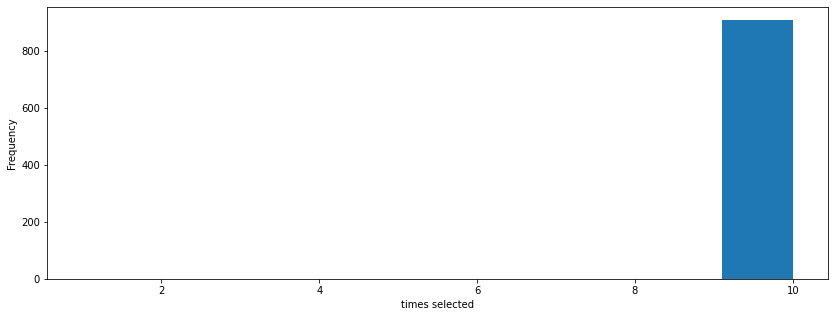

In [89]:
print(f"{len(feat_cols)} features in total")

selection_df = pd.DataFrame(data=set.union(*map(set, selected_feats)), columns=["feature"])
selection_df["times_selected"] = 0

for fold, feats in enumerate(selected_feats):
    print(f"fold {fold}  {len(feats)} features selected")
    selection_df.loc[selection_df.feature.isin(feats), "times_selected"] += 1

print()
print(f"{len(set.intersection(*map(set, selected_feats)))} features in intersection")
print(f"{len(set.union(*map(set, selected_feats)))} features in union")

ax = selection_df["times_selected"].plot(kind="hist", bins=10, figsize=(14,5))
plt.xlabel("times selected")

In [90]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.7712796196564097
ACC: 0.8211797015904246
KAPPA: 0.7556166333454116
LOG LOSS: 0.6309466815154308


In [91]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.49      0.50      0.49     21171
Sleep stage 2       0.83      0.85      0.84     67019
Sleep stage 3       0.87      0.71      0.78     16079
Sleep stage R       0.84      0.82      0.83     26284
Sleep stage W       0.91      0.92      0.92     64615

     accuracy                           0.82    195168
    macro avg       0.79      0.76      0.77    195168
 weighted avg       0.82      0.82      0.82    195168



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

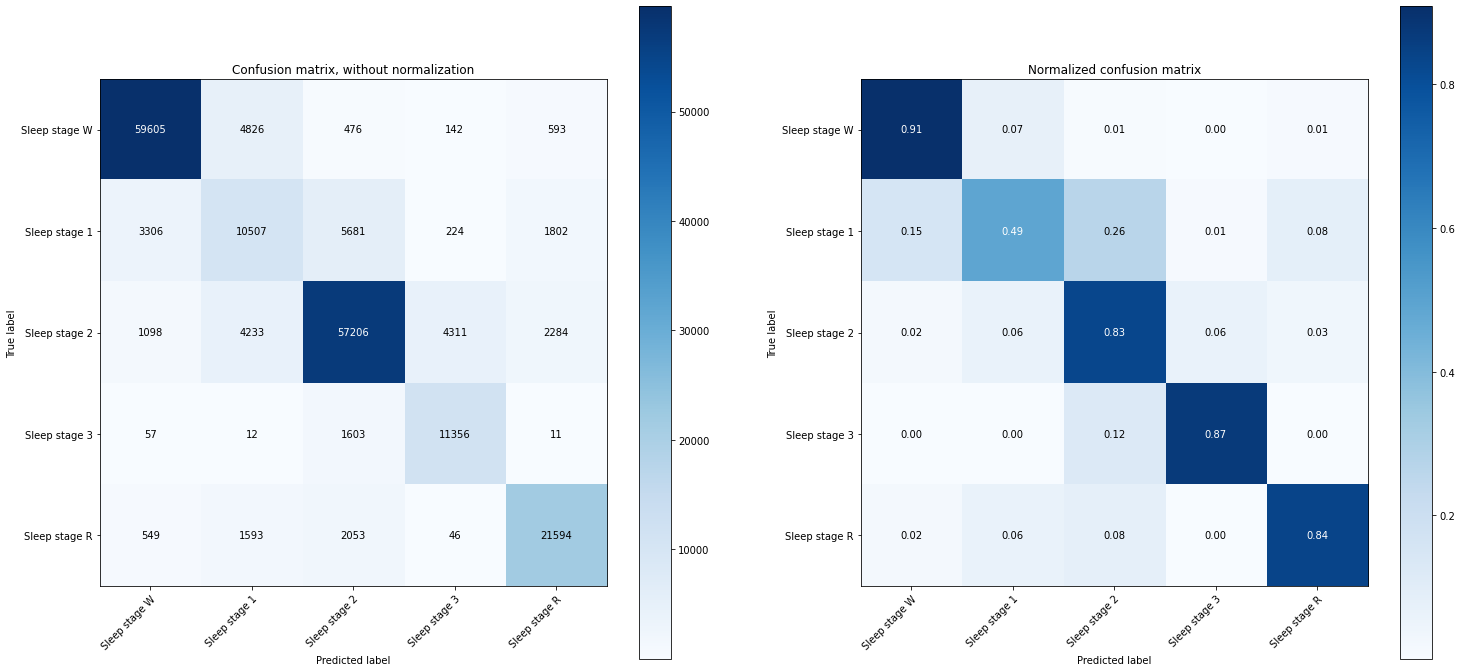

In [92]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

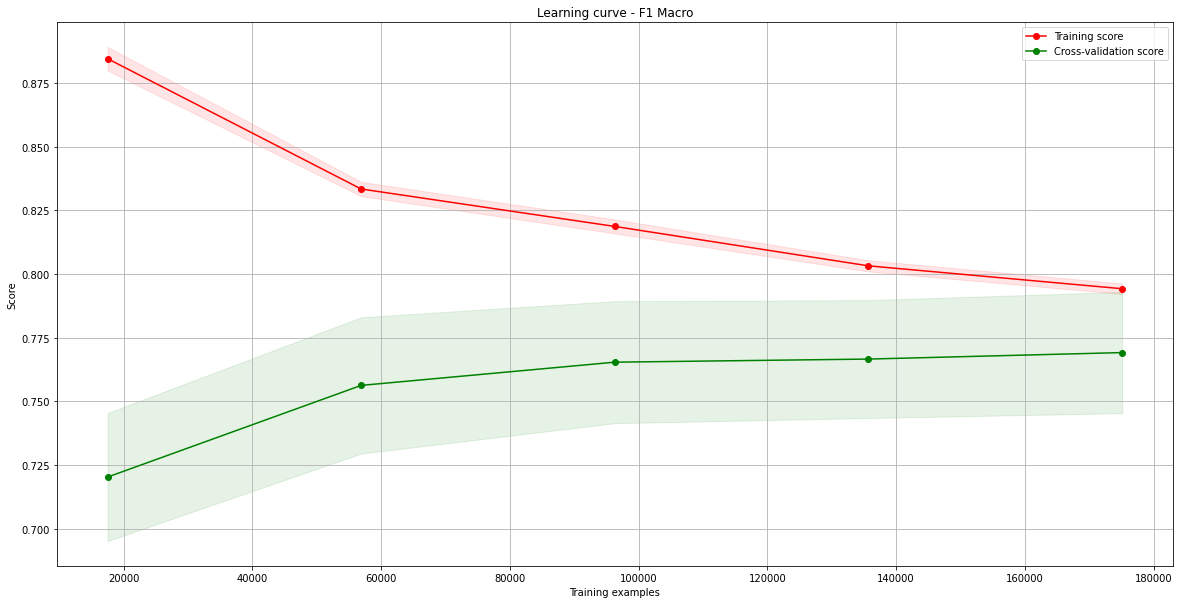

In [94]:
cv = gkfold.split(
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    groups=df_feats_trimmed_all.patient_id,
)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed_all[feat_cols],
    y=df_feats_trimmed_all["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=20,
)